## Steps

1. Load the houseprices data from Thinkful's database.


In [1]:
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
from statsmodels.tsa.stattools import acf
from sklearn.linear_model import (LinearRegression, RidgeCV, LassoCV, ElasticNetCV)
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.feature_extraction import FeatureHasher
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import (bartlett, levene)



import warnings

sns.set_style('dark')

warnings.filterwarnings('ignore')

In [2]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
hp_df = pd.read_sql_query('select * from houseprices',con=engine, index_col='id')

# No need for an open connection, as we're only doing a single query
engine.dispose()

In [3]:
hp_df.info()
hp_df.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   mssubclass     1460 non-null   int64  
 1   mszoning       1460 non-null   object 
 2   lotfrontage    1201 non-null   float64
 3   lotarea        1460 non-null   int64  
 4   street         1460 non-null   object 
 5   alley          91 non-null     object 
 6   lotshape       1460 non-null   object 
 7   landcontour    1460 non-null   object 
 8   utilities      1460 non-null   object 
 9   lotconfig      1460 non-null   object 
 10  landslope      1460 non-null   object 
 11  neighborhood   1460 non-null   object 
 12  condition1     1460 non-null   object 
 13  condition2     1460 non-null   object 
 14  bldgtype       1460 non-null   object 
 15  housestyle     1460 non-null   object 
 16  overallqual    1460 non-null   int64  
 17  overallcond    1460 non-null   int64  
 18  yearbuil

,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,bsmtfinsf2,...,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


2. Do data cleaning, exploratory data analysis, and feature engineering. You can use your previous work in this module. But make sure that your work is satisfactory.


In [4]:
# Splitting up numeric and categorical columns
non_numerics = hp_df.select_dtypes('object').columns
numerics = hp_df.select_dtypes(['int64', 'float64']).columns

In [5]:
# Multiple object columns like fireplaceqc or alley use None as the house does not have a fireplace or alley,
# so these are not true null values but actually another category.

# Converting to string from Nonetype to be counted as a category.
for col in non_numerics:
    hp_df.loc[:,col].replace(to_replace=[None], value='none', inplace=True)

In [6]:
# The columns with nulls left will not be used and therefore dropped
hp_df.drop(['lotfrontage', 'masvnrarea', 'garageyrblt'], axis=1, inplace=True)

hp_df.info()
# All nulls have been dealt with

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 77 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   mssubclass     1460 non-null   int64 
 1   mszoning       1460 non-null   object
 2   lotarea        1460 non-null   int64 
 3   street         1460 non-null   object
 4   alley          1460 non-null   object
 5   lotshape       1460 non-null   object
 6   landcontour    1460 non-null   object
 7   utilities      1460 non-null   object
 8   lotconfig      1460 non-null   object
 9   landslope      1460 non-null   object
 10  neighborhood   1460 non-null   object
 11  condition1     1460 non-null   object
 12  condition2     1460 non-null   object
 13  bldgtype       1460 non-null   object
 14  housestyle     1460 non-null   object
 15  overallqual    1460 non-null   int64 
 16  overallcond    1460 non-null   int64 
 17  yearbuilt      1460 non-null   int64 
 18  yearremodadd   1460 non-null

In [7]:
# Calling these variables again now that a few columns were dropped
non_numerics = hp_df.select_dtypes('object').columns
numerics = hp_df.select_dtypes(['int64', 'float64']).columns

# Let's look at the top correlating variables to sales price
np.abs(hp_df[numerics].iloc[:,1:].corr().loc[:,'saleprice']).sort_values(ascending=False)[:10]

saleprice       1.000000
overallqual     0.790982
grlivarea       0.708624
garagecars      0.640409
garagearea      0.623431
totalbsmtsf     0.613581
firstflrsf      0.605852
fullbath        0.560664
totrmsabvgrd    0.533723
yearbuilt       0.522897
Name: saleprice, dtype: float64

In [8]:
# Let's create a new feature for total sq ft by combining all floors
hp_df['totalsqft'] = hp_df['totalbsmtsf'] + hp_df['firstflrsf'] + hp_df['secondflrsf']
hp_df['overallqual_totalsqft'] = hp_df['totalsqft'] * hp_df['overallqual']

# Let's re-run to correlation top 10
numerics = hp_df.select_dtypes(['int64', 'float64']).columns
np.abs(hp_df[numerics].iloc[:,1:].corr().loc[:,'saleprice']).sort_values(ascending=False)[:10]

saleprice                1.000000
overallqual_totalsqft    0.856148
overallqual              0.790982
totalsqft                0.782260
grlivarea                0.708624
garagecars               0.640409
garagearea               0.623431
totalbsmtsf              0.613581
firstflrsf               0.605852
fullbath                 0.560664
Name: saleprice, dtype: float64

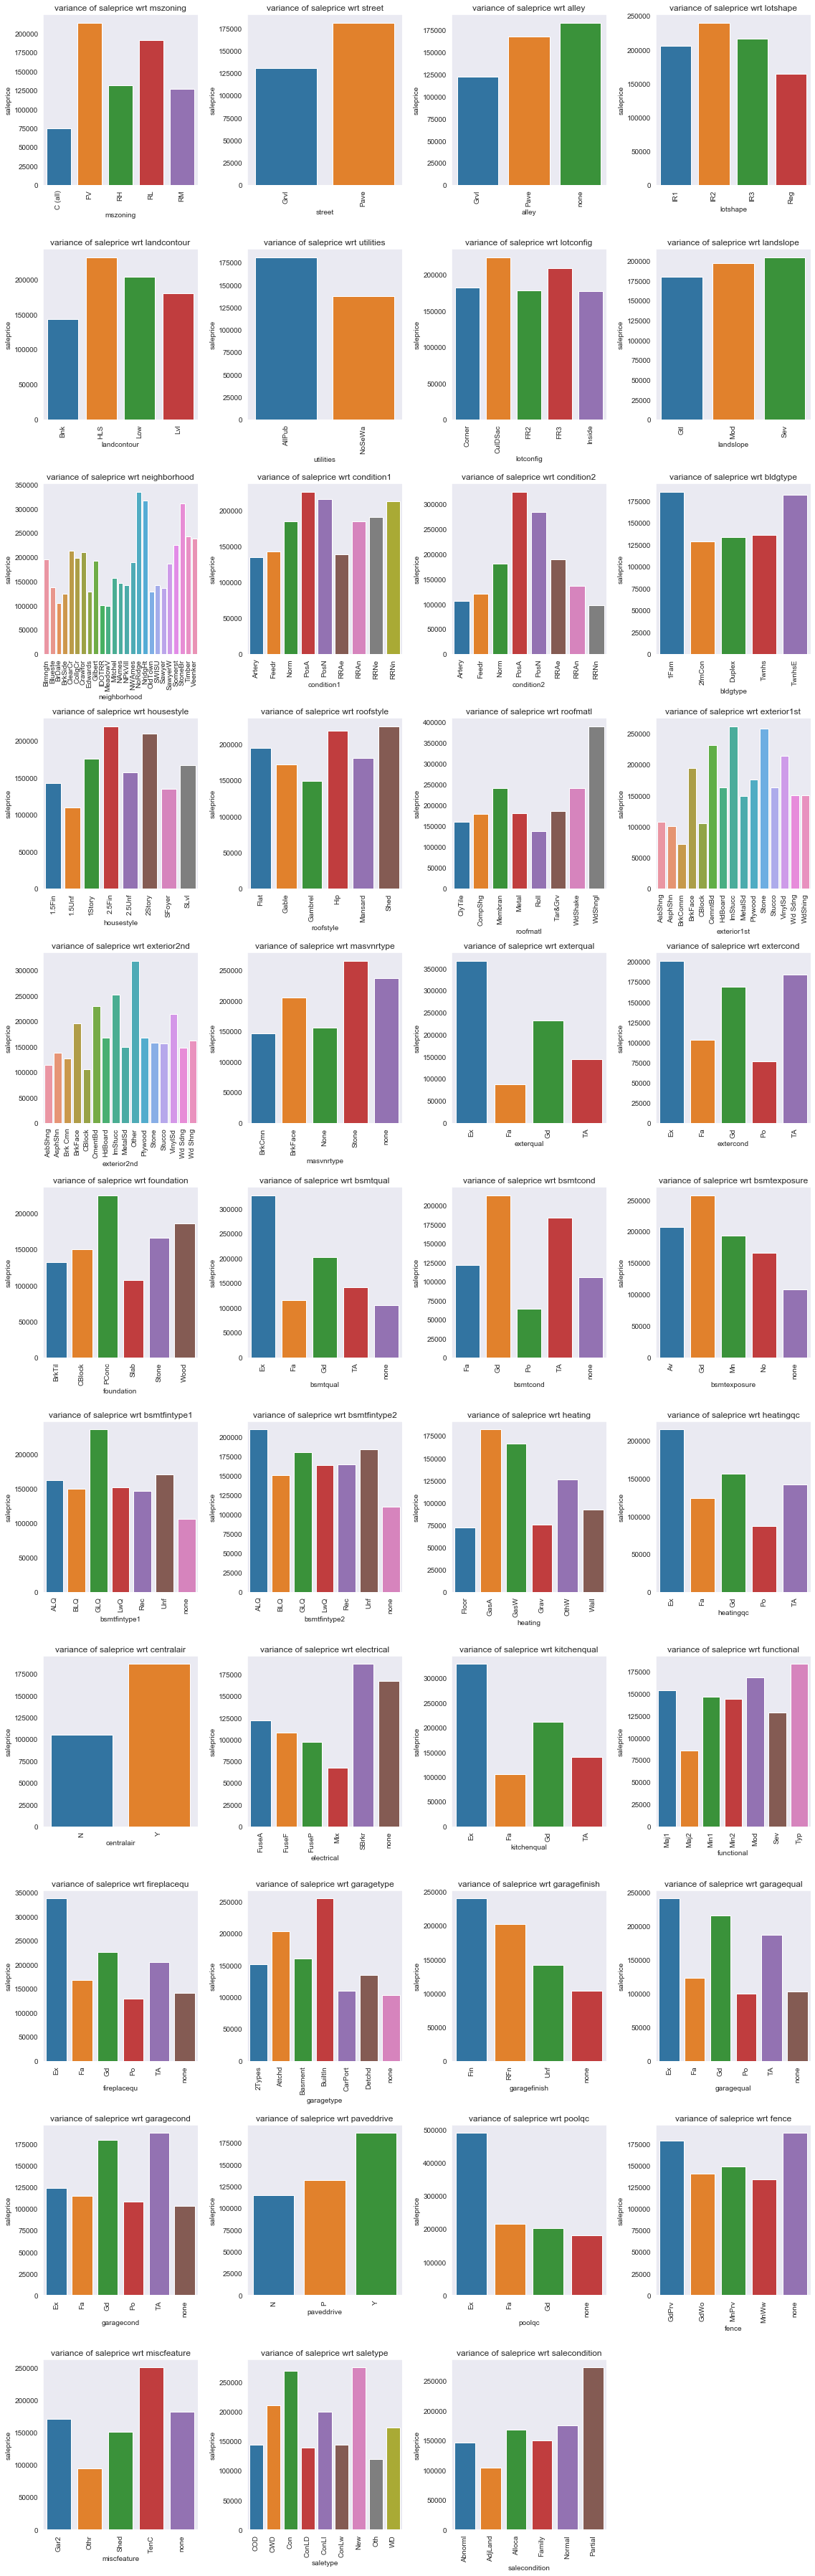

In [9]:
# Let's plot the non-numerical columns
plt.figure(figsize=(16,50))

for index, col in enumerate(non_numerics):
    plt.subplot(11, 4, index+1)
    sns.barplot(x=hp_df.groupby(col)['saleprice'].mean().index, y=hp_df.groupby(col)['saleprice'].mean())
    plt.title(f'variance of saleprice wrt {col}')
    plt.xticks(rotation='90')
    
plt.tight_layout()

# In the below we can see potential explanations of variance in mszoning, street, 
# condition2, exterqual, centralair, and garage finish

In [10]:
# Let's use a feature hasher for these categoricals and run them through a random forest regression 
# to see the importance of each of the features with respect to saleprice
hash_df = pd.DataFrame(index=np.arange(1,hp_df.shape[0]+1,1))

for col in non_numerics:
    fh = FeatureHasher(n_features=1, input_type='string')
    f = fh.fit_transform(hp_df[col])
    hash_df['hash_'+ col] = f.toarray()
    
hash_df.head()

,hash_mszoning,hash_street,hash_alley,hash_lotshape,hash_landcontour,hash_utilities,hash_lotconfig,hash_landslope,hash_neighborhood,hash_condition1,...,hash_garagetype,hash_garagefinish,hash_garagequal,hash_garagecond,hash_paveddrive,hash_poolqc,hash_fence,hash_miscfeature,hash_saletype,hash_salecondition
1,0.0,0.0,0.0,1.0,-1.0,2.0,0.0,1.0,1.0,2.0,...,-2.0,-1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,4.0
2,0.0,0.0,0.0,1.0,-1.0,2.0,1.0,1.0,3.0,3.0,...,-2.0,-1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,4.0
3,0.0,0.0,0.0,1.0,-1.0,2.0,0.0,1.0,1.0,2.0,...,-2.0,-1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,4.0
4,0.0,0.0,0.0,1.0,-1.0,2.0,2.0,1.0,3.0,2.0,...,0.0,-1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,3.0
5,0.0,0.0,0.0,1.0,-1.0,2.0,1.0,1.0,1.0,2.0,...,-2.0,-1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,4.0


In [11]:
# Running the Random Forest Regression
y = hp_df['saleprice']
X = hash_df

rfr = RandomForestRegressor(max_depth=2, random_state=0)
rfr.fit(X, y);

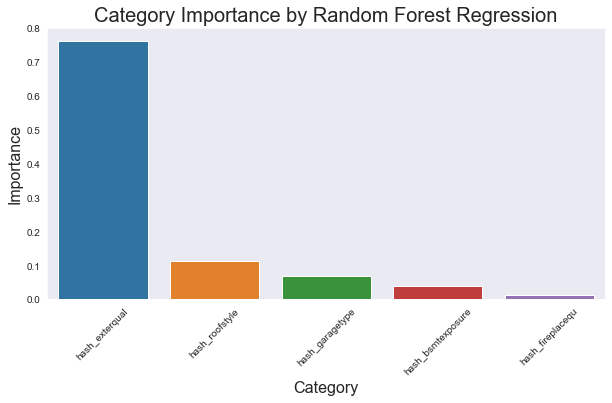

In [12]:
# Creating a df sorted by Random Forest Regression feature importances
feat_imp_df = pd.DataFrame()
feat_imp_df['categories'] = hash_df.columns
feat_imp_df['importances'] = rfr.feature_importances_
sorted_feat_imp = feat_imp_df.sort_values(by='importances', ascending=False)

# Plotting
plt.figure(figsize=(10,5))

sns.barplot(x='categories', y='importances', data=sorted_feat_imp[:5]) # most imporatant features top out at 5
plt.title('Category Importance by Random Forest Regression', fontsize=20)
plt.ylabel('Importance', fontsize=16)
plt.xlabel('Category', fontsize=16)
plt.xticks(rotation=45);

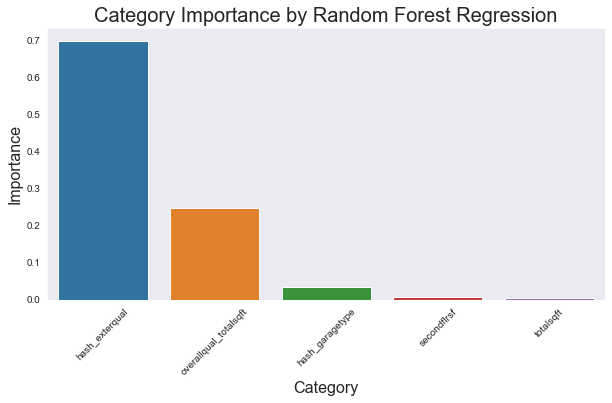

In [13]:
# Now let's add in the numerical columns, run the RFR again
hp_hash_df = pd.concat([hp_df[numerics], hash_df], axis=1)

# Dropping the target
hp_hash_df.drop('saleprice', axis=1, inplace=True)

# Running RFR again
X = hp_hash_df
rfr2 = RandomForestRegressor(max_depth=2, random_state=0)
rfr2.fit(X, y)

# Creating another df sorted by RFR feature importances
feat_imp_df2 = pd.DataFrame()
feat_imp_df2['categories'] = hp_hash_df.columns
feat_imp_df2['importances'] = rfr2.feature_importances_
sorted_feat_imp2 = feat_imp_df2.sort_values(by='importances', ascending=False)

# Plotting
plt.figure(figsize=(10,5))

sns.barplot(x='categories', y='importances', data=sorted_feat_imp2[:5])
plt.title('Category Importance by Random Forest Regression', fontsize=20)
plt.ylabel('Importance', fontsize=16)
plt.xlabel('Category', fontsize=16)
plt.xticks(rotation=45);

In [14]:
# This is interesting. I expected to see more of the top 10 highly correlated numerical columns
# place higher. Let's re-run the correlation with the hashed variables
hp_hash_sale = pd.concat([hp_hash_df, hp_df['saleprice']], axis=1)

np.abs(hp_hash_sale.corr().loc[:,'saleprice']).sort_values(ascending=False)[:10]

saleprice                1.000000
overallqual_totalsqft    0.856148
overallqual              0.790982
totalsqft                0.782260
grlivarea                0.708624
garagecars               0.640409
garagearea               0.623431
totalbsmtsf              0.613581
firstflrsf               0.605852
fullbath                 0.560664
Name: saleprice, dtype: float64

In [15]:
# For my model I will be choosing the below features and use one hot encoding as the 
# hashed features do not seem to work as well as the one hot encoded items

# One hot encoding specific variables
hp_df = pd.concat([hp_df, pd.get_dummies(hp_df['mszoning'], prefix='mszoning', drop_first=True)], axis=1)
hp_df = pd.concat([hp_df, pd.get_dummies(hp_df['exterqual'], prefix='exterqual', drop_first=True)], axis=1)
hp_df = pd.concat([hp_df, pd.get_dummies(hp_df['garagetype'], prefix='garagetype', drop_first=True)], axis=1)

dummy_col_names = list(pd.get_dummies(hp_df['mszoning'], prefix='mszoning', drop_first=True).columns)
dummy_col_names = dummy_col_names + list(pd.get_dummies(hp_df['exterqual'], 
                                                        prefix='exterqual', drop_first=True).columns)
dummy_col_names = dummy_col_names + list(pd.get_dummies(hp_df['garagetype'], 
                                                        prefix='garagetype', drop_first=True).columns)


model_df = hp_df[['overallqual_totalsqft','overallqual', 'totalsqft','grlivarea', 'garagecars', 
                       'garagearea'] + dummy_col_names]

# transforming y
y = list(np.log1p(hp_df['saleprice']))

X = model_df

3. Now, split your data into train and test sets where 20% of the data resides in the test set.


In [16]:
# Splitting up train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 900)

4. Build several linear regression models including Lasso, Ridge, or ElasticNet and train them in the training set. Use k-fold cross-validation to select the best hyperparameters if your models include one!


In [17]:
# Adding constant
X_train = sm.add_constant(X_train)

results = sm.OLS(y_train, X_train).fit()

print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     320.5
Date:                Tue, 24 Mar 2020   Prob (F-statistic):               0.00
Time:                        22:54:05   Log-Likelihood:                 502.51
No. Observations:                1168   AIC:                            -965.0
Df Residuals:                    1148   BIC:                            -863.7
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    10.04

In [18]:
# Establishing Alphas
alphas = [np.power(10.0,p) for p in np.arange(-10,40,1)]

In [19]:
# Ridge Regression
ridge_rgr = RidgeCV(alphas=alphas, cv=5)
ridge_rgr.fit(X_train, y_train)

print(f"The best alpha value is: {ridge_rgr.alpha_}")
print(f"R-squared of the model on the training set is: {ridge_rgr.score(X_train, y_train)}")

The best alpha value is: 1.0
R-squared of the model on the training set is: 0.8406392065861882


In [20]:
# Ridge Regression
LASSO_rgr = LassoCV(alphas=alphas, cv=5)
LASSO_rgr.fit(X_train, y_train)

print(f"The best alpha value is: {LASSO_rgr.alpha_}")
print(f"R-squared of the model on the training set is: {LASSO_rgr.score(X_train, y_train)}")

The best alpha value is: 1e-05
R-squared of the model on the training set is: 0.841392533377747


In [21]:
# ElasticNet Regression
ElasticNet_rgr = ElasticNetCV(alphas=alphas, cv=5)
ElasticNet_rgr.fit(X_train, y_train)

print(f"The best alpha value is: {ElasticNet_rgr.alpha_}")
print(f"R-squared of the model on the training set is: {ElasticNet_rgr.score(X_train, y_train)}")

The best alpha value is: 1e-05
R-squared of the model on the training set is: 0.8413990626953568


5. Evaluate your best model on the test set.

In [22]:
# Models are very similar, so I will just use OLS on my test set
X_test = sm.add_constant(X_test)

results = sm.OLS(y_test, X_test).fit()

y_preds = results.predict(X_test)
errors = y_test - y_preds

print(results.summary())
# Model performs better on the test set

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.875
Method:                 Least Squares   F-statistic:                     114.3
Date:                Tue, 24 Mar 2020   Prob (F-statistic):          1.10e-115
Time:                        22:54:07   Log-Likelihood:                 155.25
No. Observations:                 292   AIC:                            -272.5
Df Residuals:                     273   BIC:                            -202.6
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     9.86

In [23]:
print(f"Mean absolute error of the prediction is: {round(mean_absolute_error(y_test, y_preds), 2)}")
print(f"Mean squared error of the prediction is: {round(mse(y_test, y_preds),2)}")
print(f"Root mean squared error of the prediction is: {round(rmse(y_test, y_preds))}")
print(f"Mean absolute percentage error of the prediction is: {round(np.mean(np.abs((y_test - y_preds) / y_test) * 100),2)}%") 
#Error rate is low, but let's see if the errors tell us anything

Mean absolute error of the prediction is: 0.1
Mean squared error of the prediction is: 0.02
Root mean squared error of the prediction is: 0.0
Mean absolute percentage error of the prediction is: 0.86%


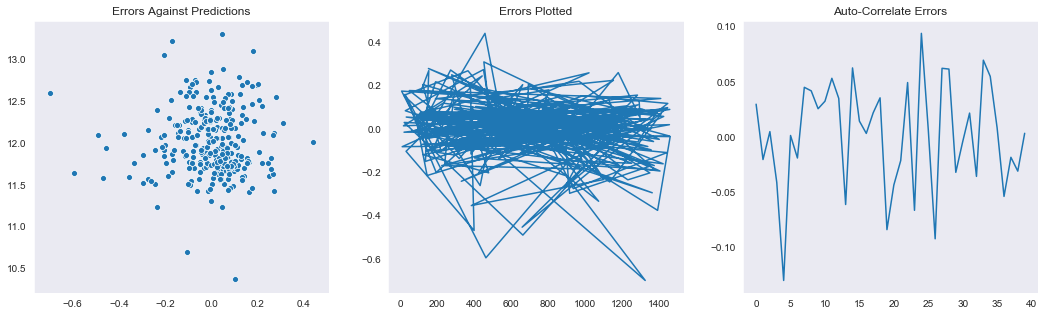

In [24]:
# Let's plot the errors to see what they tell us
acf_data = acf(errors)

plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
sns.scatterplot(errors, y_preds)
plt.title('Errors Against Predictions')
plt.subplot(1,3,2)
plt.plot(errors)
plt.title('Errors Plotted')
plt.subplot(1,3,3)
plt.plot(acf_data[1:])
plt.title('Auto-Correlate Errors');

# Errors may be homoskedastic and they are not auto-correlated

In [25]:
bart_stats = bartlett(y_preds, errors)
lev_stats = levene(y_preds, errors)

print(f"Bartlett test statistic value is {bart_stats[0]:3g} and p value is {bart_stats[1]:3g}")
print(f"Levene test statistic value is {lev_stats[0]:3g} and p value is {lev_stats[1]:.3g}")

# Stats show errors to have heteroskedasticity

Bartlett test statistic value is 256.393 and p value is 1.04901e-57
Levene test statistic value is 175.413 and p value is 3.48e-35


In [26]:
# Errors back into the dataframe and see if there are any correlations with the other features
hp_df = hp_df.merge(errors.rename('errors'), how='left', left_index=True, right_index=True)

In [27]:
hp_df['errors'].fillna(hp_df['errors'].mean(), inplace=True)

In [28]:
np.abs(hp_df.iloc[:,:].corr().loc[:,'errors']).sort_values(ascending=False)[:10]

# There are no strong correlations

errors          1.000000
bsmtunfsf       0.142826
overallcond     0.139648
saleprice       0.134872
bsmtfinsf1      0.116205
bsmtfullbath    0.108225
yearremodadd    0.076411
lotarea         0.072492
bsmtfinsf2      0.059486
bedroomabvgr    0.059124
Name: errors, dtype: float64

6. So far, you have only used the features in the dataset. However, house prices can be affected by many factors like economic activity and the interest rates at the time they are sold. So, try to find some useful factors that are not included in the dataset. Integrate these factors into your model and assess the prediction performance of your model. Discuss the implications of adding these external variables into your model.

In [29]:
# Finding useful factors not included in the data set
# https://fred.stlouisfed.org/series/MSACSR

# 30 year fixed mortgage rates by month
mortgage_rates = pd.read_csv('https://raw.githubusercontent.com/dancassin/DATA/master/MORTGAGE30US%20(1).csv',
                            header=0, names=['date', 'mortgage_rates'], parse_dates=['date'])

# Monthly supply of houses
avail_houses = pd.read_csv('https://raw.githubusercontent.com/dancassin/DATA/master/MSACSR.csv',
                          header=0, names=['date', 'avail_houses'], parse_dates=['date'])

cpi_index = pd.read_csv('https://raw.githubusercontent.com/dancassin/DATA/master/CPIHOSNS.csv',
                          header=0, names=['date', 'CPI'], parse_dates=['date'])

In [30]:
# Converting mosold and yrsold to datetime
hp_df['day'] = np.ones(1460,)
hp_df = hp_df.rename({'mosold':'month', 'yrsold':'year'}, axis='columns')
hp_df['date'] = pd.to_datetime(hp_df[['day','month','year']])

# Verifying
hp_df[['month', 'year', 'date']].head(20)

,month,year,date
id,,,
1,2,2008,2008-02-01
2,5,2007,2007-05-01
3,9,2008,2008-09-01
4,2,2006,2006-02-01
5,12,2008,2008-12-01
6,10,2009,2009-10-01
7,8,2007,2007-08-01
8,11,2009,2009-11-01
9,4,2008,2008-04-01


In [31]:
# Merging the three dataframes
hp_df = pd.merge(hp_df,mortgage_rates, on='date')
hp_df = pd.merge(hp_df, avail_houses, on='date')
hp_df = pd.merge(hp_df, cpi_index, on='date')

In [32]:
hp_df['CPI'] = hp_df['CPI'] - 100
hp_df['salesprice_CPI'] = round(((hp_df['saleprice']/hp_df['CPI'])*100)/500,1)*500

In [33]:
hp_df[['CPI','saleprice','salesprice_CPI']]

,CPI,saleprice,salesprice_CPI
0,113.026,208500,184450.0
1,113.026,129500,114600.0
2,113.026,171500,151750.0
3,113.026,120500,106600.0
4,113.026,113000,100000.0
...,...,...,...
1455,110.865,135000,121750.0
1456,110.865,207500,187150.0
1457,110.865,90000,81200.0
1458,110.865,192000,173200.0


In [34]:
# Adding the new information to the model and adjusting the target to be CPI corrected
y = list(np.log1p(hp_df['salesprice_CPI']))

X = hp_df[['overallqual_totalsqft','overallqual', 'totalsqft','grlivarea', 'garagecars', 
           'garagearea', 'mortgage_rates', 'avail_houses'] + dummy_col_names]
# Dropping columns with low p values 
X.drop(['totalsqft', 'garagearea', 'mszoning_RM', 'garagetype_CarPort', 'garagetype_Detchd'], axis=1, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)

# Adding constant
X_train = sm.add_constant(X_train)

results = sm.OLS(y_train, X_train).fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     337.4
Date:                Tue, 24 Mar 2020   Prob (F-statistic):               0.00
Time:                        22:54:11   Log-Likelihood:                 402.77
No. Observations:                1168   AIC:                            -771.5
Df Residuals:                    1151   BIC:                            -685.5
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    10.49

In [35]:
X_test = sm.add_constant(X_test)

results = sm.OLS(y_test, X_test).fit()

y_preds = results.predict(X_test)

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                     109.2
Date:                Tue, 24 Mar 2020   Prob (F-statistic):          5.70e-109
Time:                        22:54:11   Log-Likelihood:                 159.74
No. Observations:                 292   AIC:                            -285.5
Df Residuals:                     275   BIC:                            -223.0
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    10.78

In [36]:
print(f"Mean absolute error of the prediction is: {round(mean_absolute_error(y_test, y_preds), 2)}")
print(f"Mean squared error of the prediction is: {round(mse(y_test, y_preds),2)}")
print(f"Root mean squared error of the prediction is: {round(rmse(y_test, y_preds))}")
print(f"Mean absolute percentage error of the prediction is: {round(np.mean(np.abs((y_test - y_preds) / y_test) * 100),2)}%") 
#Error rate is low, but let's see if the errors tell us anything

Mean absolute error of the prediction is: 0.1
Mean squared error of the prediction is: 0.02
Root mean squared error of the prediction is: 0.0
Mean absolute percentage error of the prediction is: 0.89%


In [37]:
# The model does not perform as well with the new additions